# Init

In [15]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [16]:
import numpy as np
import scipy as sp
import json
import ast
import torch
import ase.io as aseio
torch.set_default_dtype(torch.float64)
device="cpu"
from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations

from tqdm.notebook import tqdm
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [17]:
from generate_bispectrum_structures import generate_nu3_degen_structs

# Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

### Random Boron clusters

In [4]:
np.random.seed(12345)
ngen = 1000
frames = []
for f in tqdm.tqdm(range(ngen)):
    for i in range(1000):
        r = np.random.uniform(0.5,2)
        z1 = np.random.uniform(0.5,2)
        z2 = np.random.uniform(1.5,1.8)
        psi = np.random.uniform(0,np.pi)
        phi1 = np.random.uniform(np.pi/6, np.pi)
        phi2 = np.random.uniform(np.pi/6, np.pi)
        fr = generate_nu3_degen_structs(r, [0, phi1, phi1+phi2], 
                                   psi, z1, z2, "B", "B", "B")
        dist = fr[0].get_all_distances()
        if dist[0,1:].min()>1.5 and dist[0,1:].max()<1.8 and np.abs(dist-1.0).flatten().min()>0.5:
            fr[0].info["pars"] = str((f, "+")+(r, z1, z2, psi, phi1, phi2))
            fr[1].info["pars"] = str((f, "-")+(r, z1, z2, psi, phi1, phi2))
            break
    if (i>990):
        print("oops!")
    frames += fr

In [5]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

/home/michele/local/lib/python3.8/site-packages/chemiscope/input.py:195: UserWarning: chemiscope behavior changed to no longer include properties from the structure objects. Use `chemiscope.extract_properties` to also visualize these properties ([pars])
  warnings.warn(


In [25]:
frames[134*2].info["pars"]

"(134, '+', 1.2313367121339533, 1.07392163993562, 1.6947503705446838, 0.9633078988888877, 1.993842337599831, 1.6583212922073822)"

In [7]:
aseio.write("/tmp/b8.xyz", frames)

### Mg clusters

In [9]:
frames_mg = []
n1, n2, n3 = 8,8,8
for psi in np.linspace(np.pi/6, np.pi*5/6, n1):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, n2):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, n3):
            frames_mg += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [10]:
# shuffles keeping pairs together for easier analysis
idx = np.asarray(range(len(frames_mg)//2), dtype=int)
np.random.shuffle(idx)
nfr = []
for i in idx:
    nfr.append(frames_mg[2*i])
    nfr.append(frames_mg[2*i+1])
frames_mg = nfr

In [58]:
cs = chemiscope.show(frames=frames_mg, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [66]:
aseio.write("/tmp/mg8.xyz", frames_mg)

# Loads pre-computed clusters

In [4]:
frames = aseio.read("data/three_center/boron/boron8_4000_pbeccpvdz.xyz", ":1000")

In [5]:
# explicit name for manifold parameters, and baseline for energy
e0 = -198.11364281310415
for fi, f in enumerate(frames):
    f.info["energy_rel_eV"] = (f.info["energy_ha"]-e0)*27.211386
    for n, v in zip( ("index", "label","r", "z_1", "z_2", "psi", "phi_1", "phi_2"), ast.literal_eval(f.info["pars"]) ):
        f.info[n] = v
    if fi%2 ==1:
        frames[fi].info["delta"] = np.abs(frames[fi].info["energy_rel_eV"]-frames[fi-1].info["energy_rel_eV"])
        frames[fi-1].info["delta"] = frames[fi].info["delta"]

In [6]:
cs = chemiscope.show(frames=frames, properties=chemiscope.extract_properties(frames), settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": …

# Compute raw expansion coefficients

In [7]:
hypers = {
    "cutoff": 2.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm_rho1

In [8]:
rho1i

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center']
           1             1                    0                   5
           1             1                    1                   5
           1             1                    2                   5
           1             1                    3                   5

In [9]:
rho1i.block(0)

TensorBlock
    samples (1000): ['structure', 'center']
    components (1): ['spherical_harmonics_m']
    properties (2): ['species_neighbor_1', 'n_1']
    gradients: no

In [10]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
for b in gij.blocks():
    b.values[:]/=norm_rho1

In [11]:
gij

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor']
           1             1                    0                   5                5
           1             1                    1                   5                5
           1             1                    2                   5                5
           1             1                    3                   5                5

In [12]:
gij.block(0)

TensorBlock
    samples (8000): ['structure', 'center', 'neighbor']
    components (1): ['spherical_harmonics_m']
    properties (2): ['n_1']
    gradients: no

## Test there is consistency at the level of rhoij and gij

In [13]:
test = operations.sum_over_samples(gij, samples_names=["neighbor"]) 

In [14]:
test.block(1).values;

In [15]:
np.linalg.norm(rho1i.block(1).values/test.block(1).values -1)

7.568891221116074e-13

# Now compute the correlation stuff!

In [16]:
cg = ClebschGordanReal(5)

## pair features

In [17]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 6.52 s, sys: 208 ms, total: 6.73 s
Wall time: 6.72 s


In [18]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

CPU times: user 5.38 s, sys: 116 ms, total: 5.49 s
Wall time: 5.49 s


### sanity checks

In [19]:
# nb: we disable lexicographic sorting of L to have comparable feature layout
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3, sorted_l=False)
test = operations.sum_over_samples(rhoii1i2_nu0, samples_names=["neighbor_1", "neighbor_2"]) 

In [20]:
np.linalg.norm(rho2i_full.block(2).values/test.block(2).values-1)

2.395485600100662e-10

## higher-order 

In [21]:
%%time
# here we use all tricks to reduce cost
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0)

CPU times: user 5.78 s, sys: 375 ms, total: 6.15 s
Wall time: 6.15 s


In [22]:
%%time 
#rho5il1 = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [23]:
%time 
#rho6il1 = cg_increment(rho5il1, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [24]:
%time 
#rho7i = cg_increment(rho6il1, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs


## PCA

Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [25]:
from sklearn.decomposition import PCA

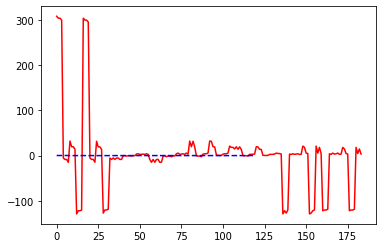

In [26]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [27]:
raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw)/ np.sqrt((raw**2).sum(axis=1).mean()), device=device)

In [28]:
triplet_samples = rhoii1i2_nu1.block(0).samples

In [29]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()),device=device)

In [30]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()),device=device)

38


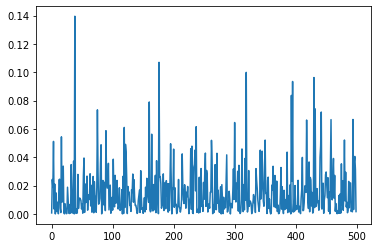

In [31]:
deltas = np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1).cpu().numpy())/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1).cpu().numpy())
plt.plot(deltas )
print(deltas.argmax())

In [32]:
cs = chemiscope.show(frames=frames, properties = { 
 "feats12345":    feats_nu12345[:,:8].cpu().numpy(),
 "type" : [i%2 for i in range(len(frames))],
 "deltas" : [deltas[i//2]   for i in range(len(frames)) ],
 "pars" : [f.info["pars"] for f in frames]   
}
                     , settings = {
                         'map': {'x': {'max': 0.8114175656679125,
   'min': -0.32173653263255847,
   'property': 'feats12345[1]',
   'scale': 'linear'},
  'y': {'max': 0.5533810292695732,
   'min': -0.29561319677262154,
   'property': 'feats12345[2]',
   'scale': 'linear'},
  'color': {'max': 0.15750915598126383,
   'min': 8.705512017627933e-08,
   'property': 'deltas',
   'scale': 'log'},
  'symbol': '',
  'palette': 'inferno',
  'size': {'factor': 50, 'mode': 'linear', 'property': '', 'reverse': False}},                         
                         'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"map": {"x": {"max": 0.8114175656679125, "min": -…

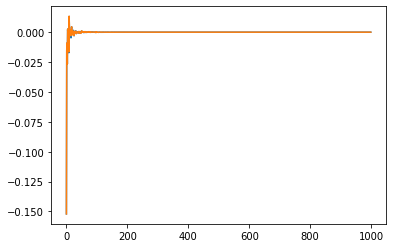

In [33]:
plt.plot(feats_nu12345[14].cpu().numpy())
plt.plot(feats_nu12345[15].cpu().numpy())

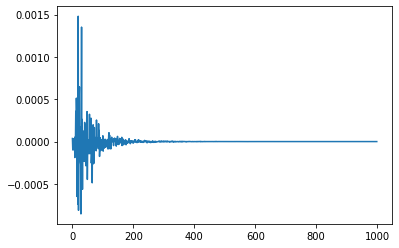

In [34]:
plt.plot((feats_nu12345[220]-feats_nu12345[221]).cpu().numpy())

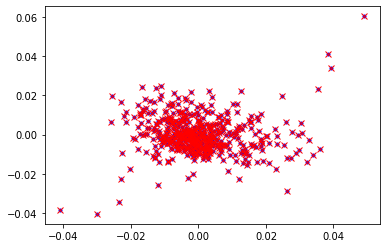

In [35]:
plt.plot(feats_nu123[::2,7].cpu().numpy(), feats_nu123[::2,8].cpu().numpy(), 'b.')
plt.plot(feats_nu123[1::2,7].cpu().numpy(), feats_nu123[1::2,8].cpu().numpy(), 'rx')

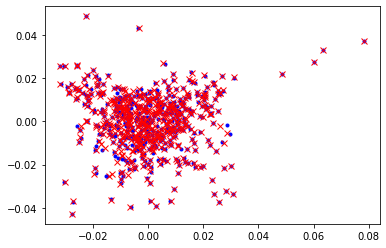

In [36]:
plt.plot(feats_nu12345[::2,8].cpu().numpy(), feats_nu12345[::2,9].cpu().numpy(), 'b.')
plt.plot(feats_nu12345[1::2,8].cpu().numpy(), feats_nu12345[1::2,9].cpu().numpy(), 'rx')

# Now we make an autoencoder thingie

In [18]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

In [19]:
class LinearEncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.layer_size = layer_size 
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, next(self.parameters()).device
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [20]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Softplus(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Softplus(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Softplus(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Softplus(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, next(self.parameters()).device
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [21]:
def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

# Prepare inputs

In [398]:

feats_nu1234567 = np.load("data/three_center/feat_1234567_PCA.npy")

In [401]:
feats_nu1234567.shape

(4000, 256)

In [158]:
energy = torch.tensor([f.info["energy_rel_eV"] for f in frames], device=device)

In [159]:
target = torch.tensor(feats_nu12345[:,:128], device=device)

In [ ]:
inputs = feats_n2nu1

In [50]:
load_ext = True
if load_ext:
    e0 = -198.11364281310415
    target = torch.tensor(np.load("data/three_center/feat_1234567_PCA.npy")[:,:64], device=device)
    energy = torch.tensor([(f.info["energy_ha"]-e0)*27.211386 for f in aseio.read("data/three_center/boron/boron8_4000_pbeccpvdz.xyz", ":")], device=device)
    inputs = torch.tensor(np.load("data/three_center/feat_3cnu1_PCA.npy")[:,:64], device=device)    

In [7]:
inputs[70*64+23][:10]

tensor([-0.0050, -0.0088,  0.0064,  0.0034, -0.0003,  0.0006, -0.0017, -0.0023,
         0.0029,  0.0008], device='cuda:0')

In [8]:
inputs[71*64+23][:10]

tensor([-0.0005,  0.0051, -0.0102,  0.0026, -0.0002,  0.0014, -0.0023,  0.0021,
        -0.0028,  0.0001], device='cuda:0')

In [12]:
target.shape, inputs.shape

(torch.Size([4000, 64]), torch.Size([256000, 64]))

38


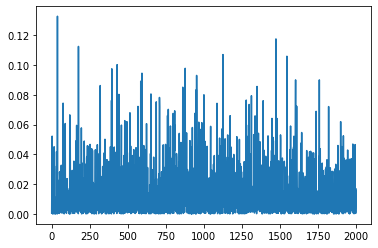

In [9]:
deltas = np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1).cpu().numpy())/np.sqrt(((target[::2]+target[1::2])**2).sum(axis=1).cpu().numpy())
plt.plot(deltas )
print(deltas.argmax())

In [8]:
mymodel = LinearEncodeDecode(64, 32, target.shape[-1])

In [10]:
mymodel = EncodeDecode(64, 32, target.shape[-1])

In [11]:
mymodel.initialize_model_weights(inputs, seed=12345)
mymodel.to(device=device)

EncodeDecode(
  (nn_encode): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (nn_decode): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=64, out_features=64, bias=True)
  )
)

# Run optimization for decoder/encoder

In [8]:
optimizer = torch.optim.Adam(
        mymodel.parameters(),
        lr=0.001
    )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 100)

NameError: name 'mymodel' is not defined

In [9]:
structure_idx = np.concatenate([ [i]*64 for i in range(len(energy))])

In [22]:
n_epochs = 20000
ntrain = 3000
ntriples = 64
for epoch in range(0, n_epochs):
    
    optimizer.zero_grad()
    predicted = mymodel(inputs[:ntrain*ntriples], structure_idx[:ntrain*ntriples])
    loss = loss_mse(predicted, target[:ntrain])
    loss.backward(retain_graph=False)
    optimizer.step()
    lr_scheduler.step(loss)
    
    if epoch % 100 ==0:
        predicted = mymodel(inputs[ntrain*ntriples:], structure_idx[ntrain*ntriples:])
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(energy)-ntrain)) )

OutOfMemoryError: CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 1.94 GiB total capacity; 1.01 GiB already allocated; 81.25 MiB free; 1.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

In [499]:
n_epochs = 10000
ntrain = 512
ntriples = 64
for epoch in range(0, n_epochs):
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(inputs[:ntrain*ntriples], structure_idx[:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
        
    if epoch % 10 ==0:
        predicted = mymodel(inputs[ntrain*ntriples:], structure_idx[ntrain*ntriples:])
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(energy)-ntrain)) )

Epoch: 0 Energy RMSE: train  0.10760958580615715 test 0.1083940130379326
Epoch: 10 Energy RMSE: train  0.1076045397662901 test 0.10838777046503507
Epoch: 20 Energy RMSE: train  0.10759684358871298 test 0.10836798676631391
Epoch: 30 Energy RMSE: train  0.10758902277384708 test 0.10835425786004738
Epoch: 40 Energy RMSE: train  0.10757776175922495 test 0.1083419745592631
Epoch: 50 Energy RMSE: train  0.10756182316494972 test 0.10834875490621786
Epoch: 60 Energy RMSE: train  0.10753717978521317 test 0.10834859957001623
Epoch: 70 Energy RMSE: train  0.10751052427015088 test 0.10836399599078107
Epoch: 80 Energy RMSE: train  0.10749126228323773 test 0.1083252620559031
Epoch: 90 Energy RMSE: train  0.10746912733379257 test 0.10831656641370883
Epoch: 100 Energy RMSE: train  0.10742671255569856 test 0.10829970596434939
Epoch: 110 Energy RMSE: train  0.10739469547766368 test 0.10824812792460192
Epoch: 120 Energy RMSE: train  0.10736768607446108 test 0.10824441742928526
Epoch: 130 Energy RMSE: tra

KeyboardInterrupt: 

In [20]:
%%time 
predicted = mymodel(inputs, structure_idx)
feats = mymodel(inputs, structure_idx)

OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 1.94 GiB total capacity; 1.01 GiB already allocated; 94.06 MiB free; 1.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
np.linalg.norm((predicted[:ntrain]-target[:ntrain]).cpu().detach() )/(
    np.linalg.norm(target[:ntrain].cpu()) )

0.12991086889906422

In [40]:
np.linalg.norm((((predicted[:ntrain:2]+predicted[1:ntrain:2])/2) - ((target[:ntrain:2]+target[1:ntrain:2])/2)).cpu().detach() )/(
    np.linalg.norm(target[:ntrain].cpu()) )

0.09100734129198965

In [41]:
np.linalg.norm((((predicted[ntrain::2]+predicted[ntrain+1::2])/2) - ((target[ntrain::2]+target[ntrain+1::2])/2)).cpu().detach() ) / (
    np.linalg.norm(target[:ntrain].cpu()) )

0.05536943489919749

In [42]:
np.linalg.norm((((predicted[:ntrain:2]-predicted[1:ntrain:2])) - ((target[:ntrain:2]-target[1:ntrain:2]))).cpu().detach() )/ (
    np.linalg.norm((target[:ntrain:2]-target[1:ntrain:2]).cpu()))

0.999999999816678

In [43]:
np.linalg.norm((((predicted[ntrain::2]-predicted[1+ntrain::2])) - 
                ((target[ntrain::2]-target[ntrain+1::2]))).cpu().detach() )/ (
    np.linalg.norm((target[ntrain::2]-target[1+ntrain::2]).cpu()))

0.9999999999340932

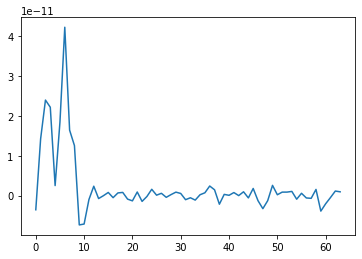

In [44]:
plt.plot(feats[30].cpu().detach()-feats[31].cpu().detach())

tensor(1368)


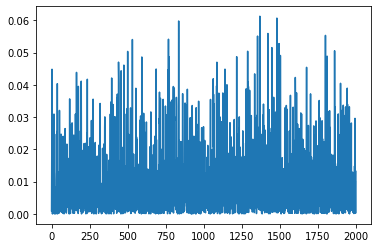

In [45]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1).cpu()))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1).cpu()).argmax())

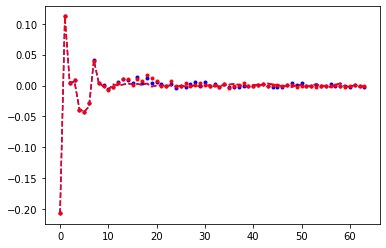

In [49]:
iframe = 1368//2
plt.plot(predicted[iframe].cpu().detach(),'b--')
plt.plot(target[iframe].cpu().detach(),'b.')
plt.plot(predicted[iframe+1].cpu().detach(), 'r--')
plt.plot(target[iframe+1].cpu().detach(), 'r.')

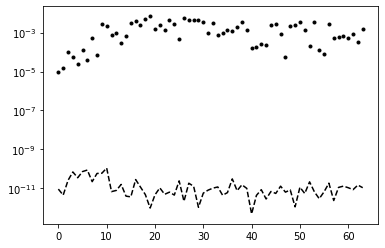

In [50]:
plt.semilogy(np.abs(predicted[iframe].detach().cpu()-predicted[iframe+1].detach().cpu()),'k--')
plt.semilogy(np.abs(target[iframe].detach().cpu()-target[iframe+1].detach().cpu()), 'k.')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

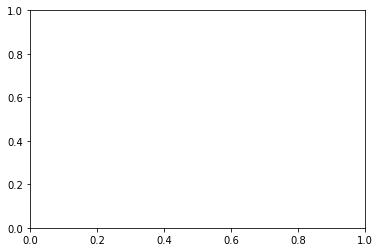

In [48]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.-')

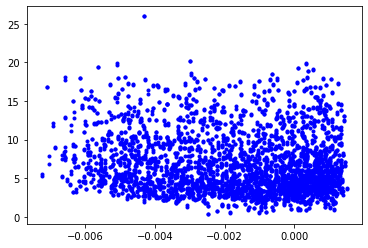

In [457]:
plt.plot(feats[:,8].detach(), energy.detach(),'b.')

# Now use learned features to predict energy

In [372]:
layer_size=80
energy_model = torch.nn.Sequential(            
            torch.nn.Linear(feats.shape[-1], layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_size, 1))

In [373]:
energy_model.to(device=device)

Sequential(
  (0): Linear(in_features=32, out_features=80, bias=True)
  (1): GroupNorm(4, 80, eps=1e-05, affine=True)
  (2): Tanh()
  (3): Linear(in_features=80, out_features=80, bias=True)
  (4): GroupNorm(4, 80, eps=1e-05, affine=True)
  (5): Tanh()
  (6): Linear(in_features=80, out_features=1, bias=True)
)

In [374]:
energy_feats = feats.clone().detach()

In [375]:
energy_optimizer = torch.optim.Adam(
        energy_model.parameters(),
        lr=0.01)

In [376]:
n_epochs = 10000
ntrain = 900
for epoch in range(0, n_epochs):
    
    energy_optimizer.zero_grad()
    loss = torch.zeros(size=(1,), device=device)

    predicted = energy_model(energy_feats[:ntrain])
    loss += loss_mse(predicted, energy[:ntrain])

    loss.backward(retain_graph=False)
    energy_optimizer.step()
    
    if epoch % 100 ==0:
        predicted = energy_model(energy_feats[ntrain:])
    
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  8.021926038840679 test 6.2433886902180555
Epoch: 100 Energy RMSE: train  3.458357119700499 test 3.7301968409672184
Epoch: 200 Energy RMSE: train  2.8975767910887744 test 2.8879660191215235
Epoch: 300 Energy RMSE: train  2.4806199088848313 test 2.462758516049793
Epoch: 400 Energy RMSE: train  2.4937557680774125 test 2.466280001261075
Epoch: 500 Energy RMSE: train  2.24715989356036 test 2.246888071773195
Epoch: 600 Energy RMSE: train  2.219951433261315 test 2.1653015818448313
Epoch: 700 Energy RMSE: train  2.1871828608828188 test 2.1536040523710893
Epoch: 800 Energy RMSE: train  2.137065832757242 test 2.1827865014732404
Epoch: 900 Energy RMSE: train  2.037976426088061 test 2.1592544367558464
Epoch: 1000 Energy RMSE: train  2.346050978954781 test 2.6743256190836013
Epoch: 1100 Energy RMSE: train  1.9533013178823762 test 2.243660561544749
Epoch: 1200 Energy RMSE: train  1.9708995517963726 test 2.119716184557284
Epoch: 1300 Energy RMSE: train  2.1118235800108875

In [377]:
energy_optimizer = torch.optim.LBFGS(
        energy_model.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128
    )

In [385]:
n_epochs = 10000
ntrain = 900
for epoch in range(0, n_epochs):
    def energy_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        energy_optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = energy_model(energy_feats[:ntrain])
        loss += loss_mse(predicted, energy[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = energy_optimizer.step(energy_step)
    
    if epoch % 10 ==0:
        predicted = energy_model(energy_feats[ntrain:])
    
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  0.0061461234115671145 test 3.7068545010092278
Epoch: 10 Energy RMSE: train  0.006139460218013025 test 3.707674910247754
Epoch: 20 Energy RMSE: train  0.006131637447358909 test 3.709090767996485
Epoch: 30 Energy RMSE: train  0.006123264148928292 test 3.709788276654845
Epoch: 40 Energy RMSE: train  0.006116332648965636 test 3.710670578420188
Epoch: 50 Energy RMSE: train  0.0061104019747710014 test 3.7111665264297176


KeyboardInterrupt: 

In [379]:
predicted = energy_model(energy_feats)

In [380]:
predicted[10]

tensor([9.1283], grad_fn=<SelectBackward0>)

In [381]:
predicted[11]

tensor([9.0069], grad_fn=<SelectBackward0>)

In [382]:
energy[10], energy[11]

(tensor(9.1295), tensor(9.0060))

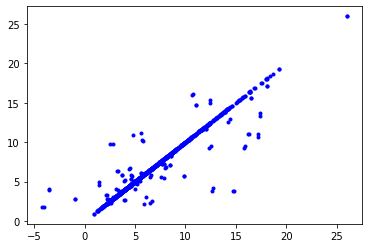

In [383]:
plt.plot(predicted.cpu().detach(), energy.cpu(),'b.')

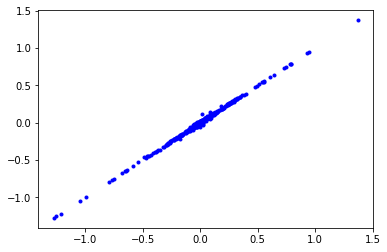

In [384]:
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[:ntrain//2], (energy[::2]-energy[1::2]).cpu()[:ntrain//2],'b.')

# Direct NICE model

## Linear

In [80]:
full_nice = torch.tensor(np.load("data/three_center/feat_1234567_PCA.npy")[:,:4000], device=device)

In [81]:
from sklearn.linear_model import RidgeCV

In [82]:
lmod = RidgeCV(alphas=np.geomspace(1e-8,1e-2,12))

In [83]:
lmod.fit(full_nice[:ntrain], energy[:ntrain])

RidgeCV(alphas=array([1.00000000e-08, 3.51119173e-08, 1.23284674e-07, 4.32876128e-07,
       1.51991108e-06, 5.33669923e-06, 1.87381742e-05, 6.57933225e-05,
       2.31012970e-04, 8.11130831e-04, 2.84803587e-03, 1.00000000e-02]))

In [84]:
lmod.alpha_

1.873817422860383e-05

In [85]:
predicted = torch.tensor(lmod.predict(full_nice))

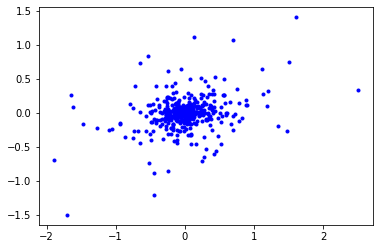

In [86]:
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[ntrain//2:], (energy[::2]-energy[1::2]).cpu()[ntrain//2:],'b.')

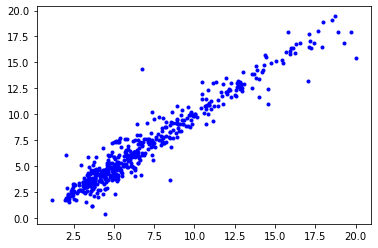

In [87]:
plt.plot((predicted[::2]+predicted[1::2]).cpu().detach()[ntrain//2:]/2, (energy[::2]+energy[1::2]).cpu()[ntrain//2:]/2,'b.')

In [88]:
print( 
    torch.sqrt(torch.mean( ((predicted[::2]+predicted[1::2]).cpu().detach().flatten()[ntrain//2:]/2-(energy[::2]+energy[1::2]).cpu().flatten()[ntrain//2:]/2)**2 )) /torch.std(energy)
    ,
    torch.sqrt(torch.mean( ((predicted[::2]-predicted[1::2]).cpu().detach().flatten()[ntrain//2:]-(energy[::2]-energy[1::2]).cpu().flatten()[ntrain//2:])**2 )) /torch.std(energy[::2]-energy[1::2])     
     )

tensor(0.2683) tensor(1.5423)


## Non-linear

In [94]:
class NICELearn(torch.nn.Module):
    def __init__(self, layer_size=100):
        super().__init__()

        self.nn_encode = None
        self.layer_size = layer_size 

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)
        layer_size  = self.layer_size
        self.learn = torch.nn.Sequential(            
            torch.nn.Linear(inputs.shape[-1], layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.SiLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.SiLU(),
            torch.nn.Linear(layer_size, 1))   
        
    def forward(self, block, samples=None):
        if self.learn is None:
            raise Exception("call initialize_weights first")

        nn_per_structure = self.learn(block)        
        return nn_per_structure

In [95]:
mymodel = NICELearn(64)
mymodel.initialize_model_weights(inputs, seed=12345)
mymodel.to(device=device)

NICELearn(
  (learn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): GroupNorm(4, 64, eps=1e-05, affine=True)
    (2): SiLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(4, 64, eps=1e-05, affine=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [96]:
optimizer = torch.optim.Adam(
        mymodel.parameters(),
        lr=0.001
    )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 100)

In [97]:
structure_idx = np.concatenate([ [i]*64 for i in range(len(energy))])

In [98]:
n_epochs = 20000
ntrain = 3000
ntriples = 64
val_best = 1e100

In [100]:
for epoch in range(0, n_epochs):
    
    optimizer.zero_grad()
    predicted = mymodel(target[:ntrain])
    loss = loss_mse(predicted, energy[:ntrain])
    loss.backward(retain_graph=False)
    optimizer.step()
    lr_scheduler.step(loss)
    
    if epoch % 10 ==0:
        predicted = mymodel(target[ntrain:])
        validation_error = np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(energy)-ntrain))
        if validation_error < val_best:
            #print("BEST Validation Error: ", validation_error)
            val_best = validation_error
            torch.save(mymodel.state_dict(), f"d-NICE-E_best.torch")

        if epoch % 100 ==0:
            print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
                 "test", validation_error )

Epoch: 0 Energy RMSE: train  8.163749447219375 test 8.145122849657819
Epoch: 100 Energy RMSE: train  4.000499233744804 test 4.057159229683771
Epoch: 200 Energy RMSE: train  2.5905421915795235 test 2.6234990346472857
Epoch: 300 Energy RMSE: train  1.647444583064619 test 1.6592264427296233
Epoch: 400 Energy RMSE: train  1.1713709426812302 test 1.3048934194802149
Epoch: 500 Energy RMSE: train  0.8713506387176786 test 1.1760243239460173
Epoch: 600 Energy RMSE: train  0.6745129449698759 test 1.1352955832192082
Epoch: 700 Energy RMSE: train  0.5588332560307795 test 1.1116962712536684
Epoch: 800 Energy RMSE: train  0.4606782344958399 test 1.0574578274243458
Epoch: 900 Energy RMSE: train  0.39115852233433196 test 1.0415752199368145
Epoch: 1000 Energy RMSE: train  0.4060732545908927 test 1.082155264413165
Epoch: 1100 Energy RMSE: train  0.31211505690433494 test 1.05124631498982
Epoch: 1200 Energy RMSE: train  0.28729200015094414 test 1.0523809984279715
Epoch: 1300 Energy RMSE: train  0.26757426

In [101]:
predicted = mymodel(target)

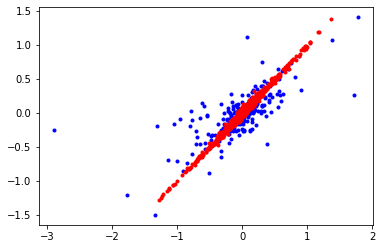

In [103]:
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[ntrain//2:], (energy[::2]-energy[1::2]).cpu()[ntrain//2:],'b.')
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[:ntrain//2], (energy[::2]-energy[1::2]).cpu()[:ntrain//2],'r.')

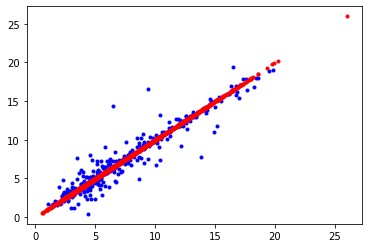

In [104]:
plt.plot((predicted[::2]+predicted[1::2]).cpu().detach()[ntrain//2:]/2, (energy[::2]+energy[1::2]).cpu()[ntrain//2:]/2,'b.')
plt.plot((predicted[::2]+predicted[1::2]).cpu().detach()[:ntrain//2:]/2, (energy[::2]+energy[1::2]).cpu()[:ntrain//2]/2,'r.')

In [105]:
print( 
    torch.sqrt(torch.mean( ((predicted[::2]+predicted[1::2]).cpu().detach().flatten()[ntrain//2:]/2-(energy[::2]+energy[1::2]).cpu().flatten()[ntrain//2:]/2)**2 )) /torch.std(energy)
    ,
    torch.sqrt(torch.mean( ((predicted[::2]-predicted[1::2]).cpu().detach().flatten()[ntrain//2:]-(energy[::2]-energy[1::2]).cpu().flatten()[ntrain//2:])**2 )) /torch.std(energy[::2]-energy[1::2])     
     )

tensor(0.2565) tensor(0.8910)


# Direct (3B) energy model

In [106]:
class EncodeLearn(torch.nn.Module):
    def __init__(self, layer_size=100):
        super().__init__()

        self.nn_encode = None
        self.layer_size = layer_size 

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)
        layer_size  = self.layer_size
        self.learn = torch.nn.Sequential(            
            torch.nn.Linear(inputs.shape[-1], layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.SiLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.SiLU(),
            torch.nn.Linear(layer_size, 1))   
    def forward(self, block, samples):
        if self.learn is None:
            raise Exception("call initialize_weights first")

        structure_map, new_samples, _ = StructureMap(
            samples, next(self.parameters()).device
        )
                
        nn_per_triple = self.learn(block)        
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=block.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure

In [107]:
mymodel = EncodeLearn(64)
mymodel.initialize_model_weights(inputs, seed=12345)
mymodel.to(device=device)

EncodeLearn(
  (learn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): GroupNorm(4, 64, eps=1e-05, affine=True)
    (2): SiLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(4, 64, eps=1e-05, affine=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [114]:
state = torch.load("./d-NL-E_best.torch")
print("Restarting model parameters from file")
mymodel.load_state_dict(state)


Restarting model parameters from file


<All keys matched successfully>

In [115]:
optimizer = torch.optim.Adam(
        mymodel.parameters(),
        lr=0.001
    )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 100)

In [116]:
structure_idx = np.concatenate([ [i]*64 for i in range(len(energy))])

In [123]:
n_epochs = 40000
ntrain = 3000
ntriples = 64
val_best = 1e100

In [ ]:
for epoch in range(0, n_epochs):
    
    optimizer.zero_grad()
    predicted = mymodel(inputs[:ntrain*ntriples], structure_idx[:ntrain*ntriples])
    loss = loss_mse(predicted, energy[:ntrain])
    loss.backward(retain_graph=False)
    optimizer.step()
    lr_scheduler.step(loss)
    
    if epoch % 10 ==0:
        predicted = mymodel(inputs[ntrain*ntriples:], structure_idx[ntrain*ntriples:])
        validation_error = np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(energy)-ntrain))
        if validation_error < val_best:
            #print("BEST Validation Error: ", validation_error)
            val_best = validation_error
            torch.save(mymodel.state_dict(), f"d-NL-E_best.torch")

        if epoch % 100 ==0:
            print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
                 "test", validation_error )

Epoch: 0 Energy RMSE: train  0.03866221775736658 test 0.1270942970573842
Epoch: 100 Energy RMSE: train  0.03864333384741849 test 0.127629170351612
Epoch: 200 Energy RMSE: train  0.03863139625696023 test 0.12760993137952373
Epoch: 300 Energy RMSE: train  0.03861929257373391 test 0.12759536642770528
Epoch: 400 Energy RMSE: train  0.03860674750855365 test 0.1275817833005085
Epoch: 500 Energy RMSE: train  0.03859366853849055 test 0.12756827789396205
Epoch: 600 Energy RMSE: train  0.03858000061504238 test 0.12755454466469074
Epoch: 700 Energy RMSE: train  0.03856570108264651 test 0.1275404368317781
Epoch: 800 Energy RMSE: train  0.038550731971969926 test 0.1275258636177657
Epoch: 900 Energy RMSE: train  0.050429633222902406 test 0.1271391314988331
Epoch: 1000 Energy RMSE: train  0.038527054190314554 test 0.1275010613413927
Epoch: 1100 Energy RMSE: train  0.038512772389871185 test 0.1275021801189095
Epoch: 1200 Energy RMSE: train  0.038498981692116296 test 0.12748650442916548
Epoch: 1300 Ene

In [125]:
predicted = mymodel(inputs, structure_idx)

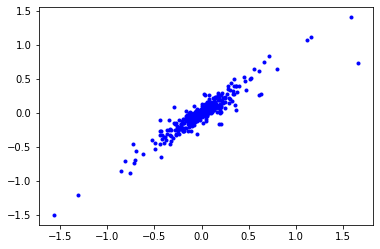

In [126]:
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[ntrain//2:], (energy[::2]-energy[1::2]).cpu()[ntrain//2:],'b.')

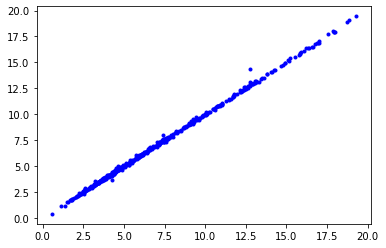

In [127]:
plt.plot((predicted[::2]+predicted[1::2]).cpu().detach()[ntrain//2:]/2, (energy[::2]+energy[1::2]).cpu()[ntrain//2:]/2,'b.')

In [128]:
print( 
    torch.sqrt(torch.mean( ((predicted[::2]+predicted[1::2]).cpu().detach().flatten()[ntrain//2:]/2-(energy[::2]+energy[1::2]).cpu().flatten()[ntrain//2:]/2)**2 )) /torch.std(energy)
    ,
    torch.sqrt(torch.mean( ((predicted[::2]-predicted[1::2]).cpu().detach().flatten()[ntrain//2:]-(energy[::2]-energy[1::2]).cpu().flatten()[ntrain//2:])**2 )) /torch.std(energy[::2]-energy[1::2])     
     )

tensor(0.0306) tensor(0.3511)


In [38]:
torch.sqrt(torch.mean( ((predicted-energy).cpu()[ntrain:])**2 )) 

tensor(5.5543, grad_fn=<SqrtBackward0>)

In [50]:
torch.std(energy.cpu().flatten()-predicted.cpu().flatten())

tensor(0.2809, grad_fn=<StdBackward0>)

In [46]:
predicted.shape

torch.Size([4000, 1])

In [ ]:
plt.plot(energy.cpu()-predicted.cpu()